# $S_0$ Schnittstelle des eHz auslesen

* S0 Wiki: https://de.wikipedia.org/wiki/S0-Schnittstelle
* Terminal Wiki: http://www.tldp.org/HOWTO/Text-Terminal-HOWTO-15.html
* RPi Serial: https://elinux.org/RPi_Serial_Connection

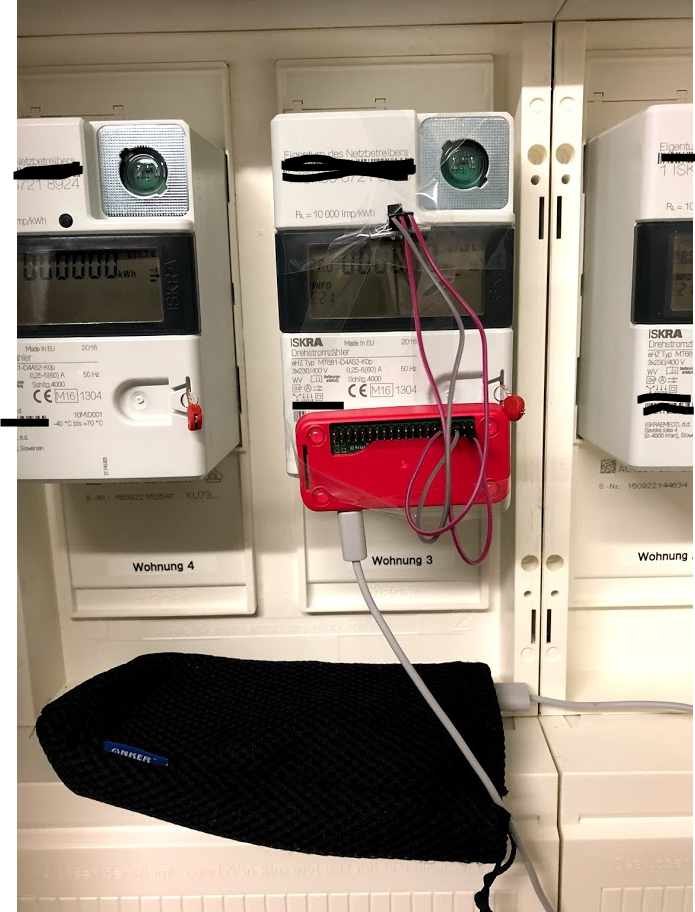

Der IR Kopf hängt beim aktuellen Raspbian über die serielle Schnittstelle des Raspberry an `/dev/serial0`. GPIO Belegung siehe Bild. Da wir die $S_0$ Schnittstelle des Stromzählers benutzen sind 10.000 Impulse 1kWh. Um live mitzulesen nutzen wir ein `bash` Skript. Das läßt sich noch verbessern, ich hatte noch Probleme beim pipen mit `awk`.

# Logging per `bash`

Vorbereiten des Terminals mit: `stty time 1 min 1 -icanon < /dev/serial0`

Interpretieren der Zeichenübertragung: https://social.msdn.microsoft.com/Forums/vstudio/en-US/fe68e7aa-d9d6-406c-b663-4d52f759dbab/receive-wrong-caracters-from-serial-port?forum=vbgeneral

Sniffing des serial ports: `strace -ttt -o /home/pi/Desktop/smartmeter.txt -e write cat < /dev/serial0 2>&1`

# Alternativcode zum Loggen in Python für den RPI

In [ ]:
# Alternativ könnten wir auch ein Python Programm schreiben, das wir auf dem Raspberry ausführen um die serielle Schnittstelle auszulesen.
import serial
import csv
import datetime

serialport = serial.Serial("/dev/serial0", 9600, timeout=0.5)

with open("smartmeter.csv", "a") as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=' ', quotechar='|')
    
    while True:    
        value = serialport.read()
        csvwriter.writerow([str(datetime.datetime.now()), str(value)])

# Datenexploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [2]:
%matplotlib inline
plt.style.use('ggplot')

In [17]:
path = r'C:\Users\Andreas.Hopfgartner\OneDrive - b.telligent GmbH & Co. KG\Projekte\test projects'
filenames = glob.glob(path + "/*.txt")

In [26]:
smartmeter_df = pd.concat([pd.read_csv(f, header=None, delim_whitespace=True).drop(columns=[1,2,3,4]) for f in filenames])
smartmeter_df.columns = ["timestamp", "value"]
smartmeter_df["timestamp"] = pd.to_datetime(smartmeter_df["timestamp"], origin='unix', unit="s")
smartmeter_df.set_index("timestamp", inplace=True)
smartmeter_df = smartmeter_df[(smartmeter_df["value"] == 1) | (smartmeter_df["value"] == '1')]
smartmeter_df["value"] = pd.to_numeric(smartmeter_df["value"])

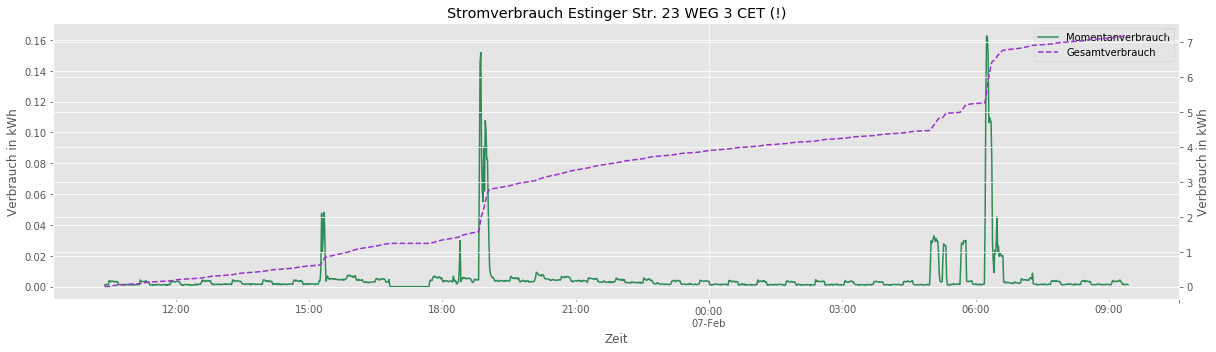

In [27]:
fig, ax1 = plt.subplots(figsize=(17,5))
smartmeter_df.resample("min").sum().divide(10000, axis="value").plot(y="value", ax=ax1, color="seagreen", label="Momentanverbrauch")

ax2 = ax1.twinx()
smartmeter_df.resample("min").sum().cumsum().divide(10000, axis="value").plot(y="value", style='--',ax=ax2, color="darkorchid", label="Gesamtverbrauch")

lns = ax1.lines + ax2.lines
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
ax2.legend([])

ax1.set_ylabel("Verbrauch in kWh")
ax2.set_ylabel("Verbrauch in kWh")
ax1.set_xlabel("Zeit")
ax1.set_title("Stromverbrauch Estinger Str. 23 WEG 3 CET (!)")

fig.tight_layout()

Überprüfen mit 2x Werte ablesen und Plausicheck!

Im Graph oben sieht man schön den Kühlschrank, der alle Stunde mal anspringt. Der erste größere Peak ist die Mikrowelle. Das leicht erhöhte Grundaufkommen um die Zeit müsste das Laden des Staubsaugerroboters sein.